## Importing required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install text_hammer
import text_hammer as th
from nltk.corpus import stopwords
import random
from collections import defaultdict
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
sns.set()

from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.layers import Dropout
import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Loading the data and getting the basic idea

In [3]:
df = pd.read_csv('train.csv')
df.sample(10)

,id,keyword,location,text,target
287,420,apocalypse,"Buenos Aires, Argentina",candylit: Imagine sarumi in a zombie apocalyps...,0
1784,2560,crash,NaN,@SterlingKnight Who had a car crashsterling!W...,0
5374,7670,panic,"Palm Bay, FL (Kissimmee)",Panic over: Patient in Alabama tests negative ...,1
3527,5041,eyewitness,Los Angeles... CA... USA,Aug. 06 2015 Radio Show articles ÛÒ \n1] Eye...,0
6685,9579,thunder,nowhere,Super loud thunder woke me up from my very nic...,0
383,552,arson,"Charlotte, NC",Add Familia to the arson squad.,0
4076,5794,hail,"Hattiesburg, MS",Two great 'dawgs' Dak and Jak !!! HAIL STATE ...,0
4043,5743,forest%20fires,"Washington, D.C.",As California fires rage Forest Service sounds...,1
5672,8095,rescued,NaN,Britons rescued amid Himalaya floods (http://t...,1
7199,10314,weapon,"California, United States",#InsaneLimits #plugin enabled @' =TPS= | T...,0


In [4]:
print(f"Total  samples: {len(df)}")


Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

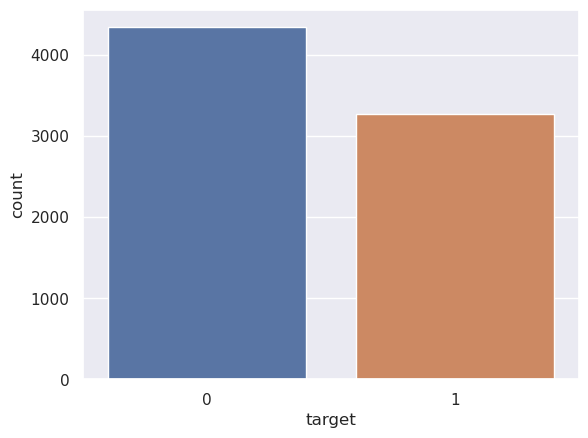

In [7]:
sns.countplot(x = df['target'])
plt.show()

In [8]:
df = df.drop('id',axis = 1)


## Exploratory Data Analysis

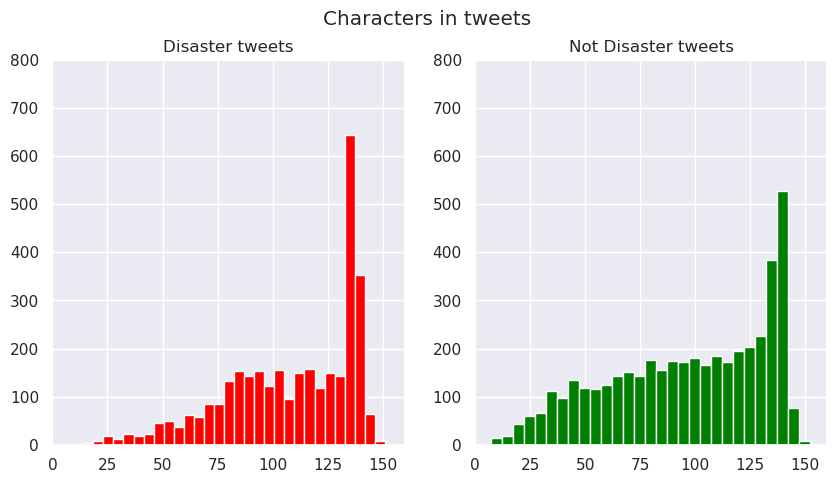

In [9]:
# Number of characters in tweets

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

df_len=df[df['target']==1]['text'].str.len()
ax1.hist(df_len,color='red',bins =30)
ax1.set_title('Disaster tweets')
ax1.set_xlim(0,160)
ax1.set_ylim(0,800)

df_len =df[df['target']==0]['text'].str.len()
ax2.hist(df_len,color='green',bins =30)
ax2.set_title('Not Disaster tweets')
ax2.set_xlim(0,160)
ax2.set_ylim(0,800)

fig.suptitle('Characters in tweets')
plt.show()

**120 to 140 characters are most common both for disaster and non disaster tweets.**

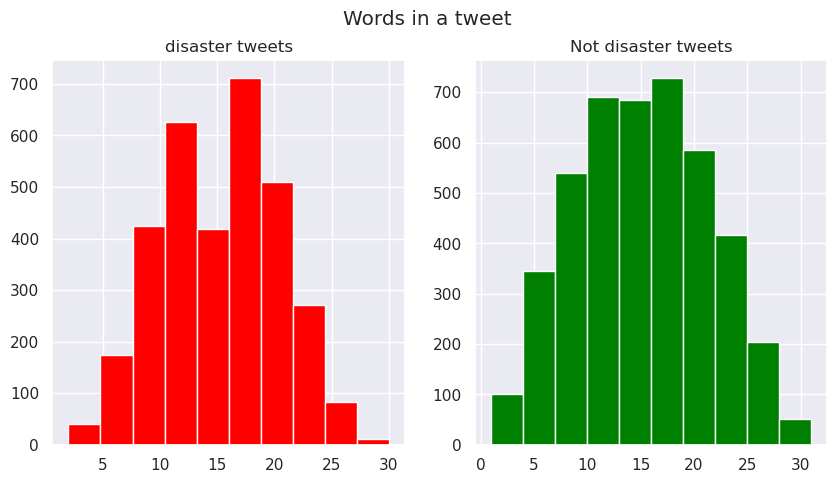

In [10]:
# Number of words in a tweet

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

df_len=df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(df_len,color='red')
ax1.set_title('disaster tweets')

df_len=df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(df_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

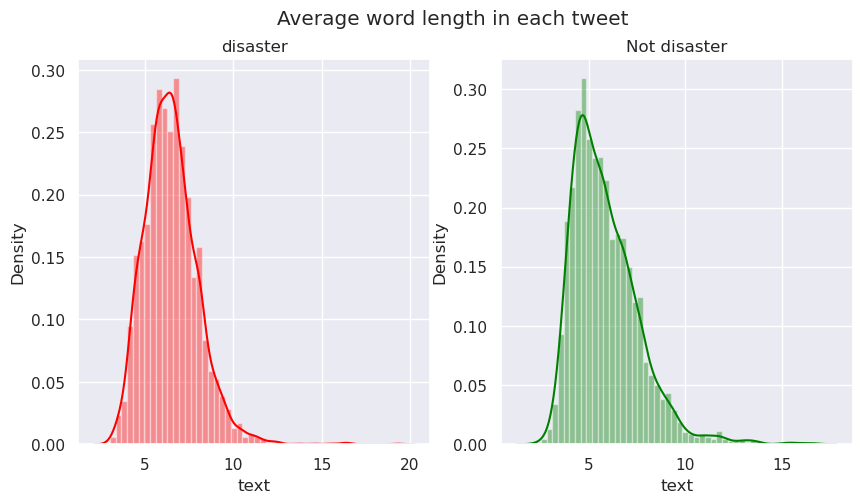

In [11]:
# Average word length in a tweet

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word = df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')

word = df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')

fig.suptitle('Average word length in each tweet')

In [12]:
def create_corpus(target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

## Common stopwords in tweets

<BarContainer object of 10 artists>

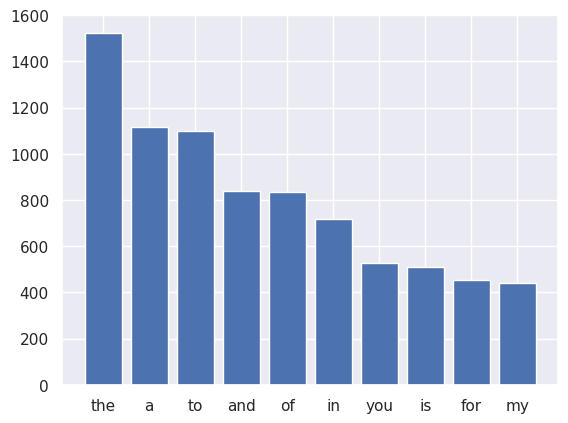

In [13]:
stop=set(stopwords.words('english'))

# Tweets with class 0
corpus=create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

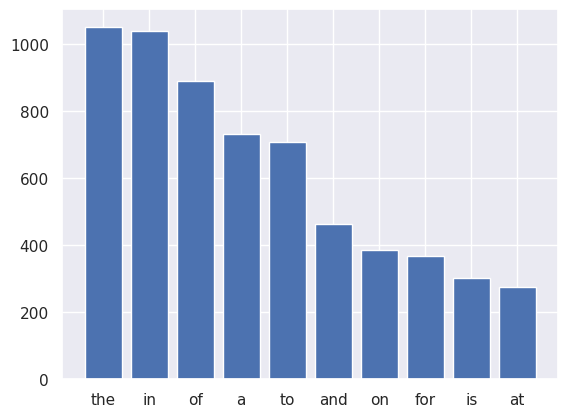

In [14]:
# Tweets with class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

In [15]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

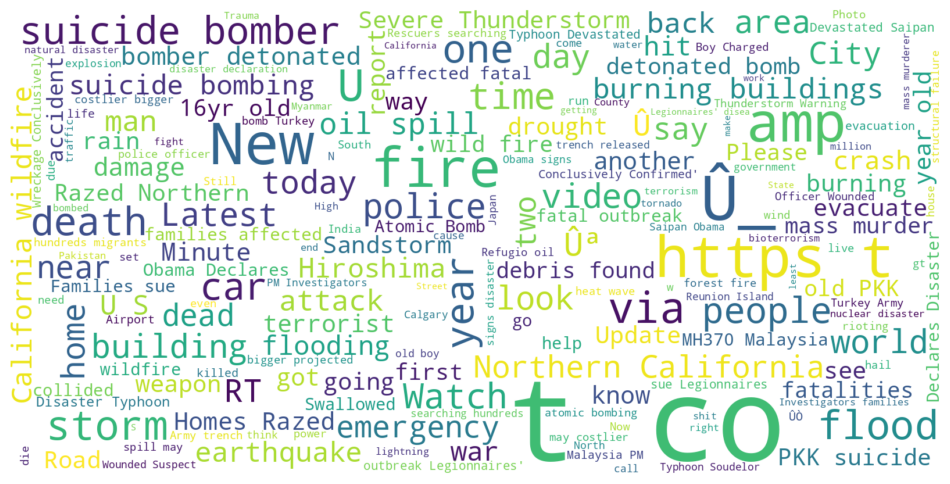

In [16]:
# Disaster Tweets wordcloud 

disaster_tweets = df[df.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

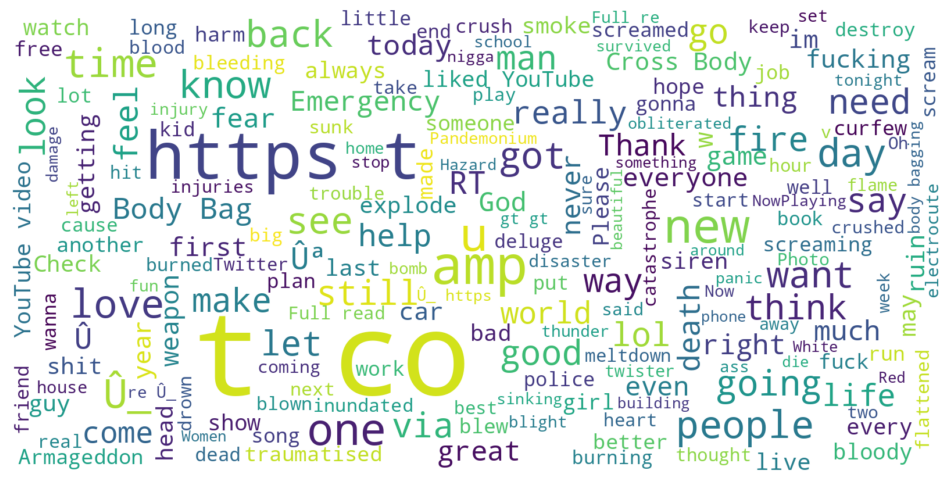

In [17]:
# Positive tweets wordcloud

formal_tweets = df[df.target == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Cleaning

**As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will randomly visualize some tweets and will see what extra stuff is not needed and will remove it.**

In [18]:
# Let's visualize some random training examples

random_index = random.randint(0, len(train)-5) # create random indexes not higher than the total number of samples
for row in df[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Hear @DrFriedenCDC talk avoid thousands resistant infections/deaths next 5 yrs: http://t.co/niV8x5Tbe0 #AdiosSuperBacterias

---

Target: 0 (not real disaster)
Text:
Irony died thousand deaths! ???? http://t.co/dBU30ObDxz

---

Target: 0 (not real disaster)
Text:
@StrickSkin @NicksComics Lol usually I'm objective here. Maybe Uncle Ben course. Most deaths end business usual

---

Target: 1 (real disaster)
Text:
[Comment] Deaths older children: data tell #US? http://t.co/p8Yr2po6Jn #nghlth

---

Target: 1 (real disaster)
Text:
Deaths 7 http://t.co/xRJA0XpL40

---



In [20]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

    return(df)

In [21]:
df = text_preprocessing(df,'text')

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

In [22]:
# Use train_test_split to split training data into training and validation sets

train_sentences, val_sentences, train_labels, val_labels = train_test_split(df["text"].to_numpy(),
                                                                            df["target"].to_numpy(),
                                                                            test_size=0.15, 
                                                                            random_state=42)

In [23]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6471, 6471, 1142, 1142)

## Text vectorization (tokenization)

In [24]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

11

In [25]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 11 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [26]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

## Creating an Embedding using an Embedding Layer

In [27]:

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

## Modelling

### Model 0: Naive Bayes (baseline)

In [28]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.15936952714536,
 'precision': 0.7996783232344097,
 'recall': 0.7915936952714536,
 'f1': 0.7857389048776391}

### Model 1: Feed-forward neural network (dense model)

In [32]:
# Build model with the Functional API

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 11)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 11, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Fit the model
model_1_history = model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
203/203 [==============================] - 4s 16ms/step - loss: 0.6108 - accuracy: 0.7110 - val_loss: 0.5344 - val_accuracy: 0.7776
Epoch 2/5
203/203 [==============================] - 3s 15ms/step - loss: 0.4262 - accuracy: 0.8337 - val_loss: 0.4640 - val_accuracy: 0.8021
Epoch 3/5
203/203 [==============================] - 3s 14ms/step - loss: 0.3208 - accuracy: 0.8759 - val_loss: 0.4613 - val_accuracy: 0.8004
Epoch 4/5
203/203 [==============================] - 3s 14ms/step - loss: 0.2551 - accuracy: 0.9065 - val_loss: 0.4754 - val_accuracy: 0.7793
Epoch 5/5
203/203 [==============================] - 3s 14ms/step - loss: 0.2066 - accuracy: 0.9237 - val_loss: 0.5042 - val_accuracy: 0.7820


In [34]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) 

# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

36/36 [==============================] - 0s 2ms/step


{'accuracy': 78.19614711033275,
 'precision': 0.7827189180050202,
 'recall': 0.7819614711033275,
 'f1': 0.7789942805138658}

Text(0.5, 1.0, 'Model_1 training curves')

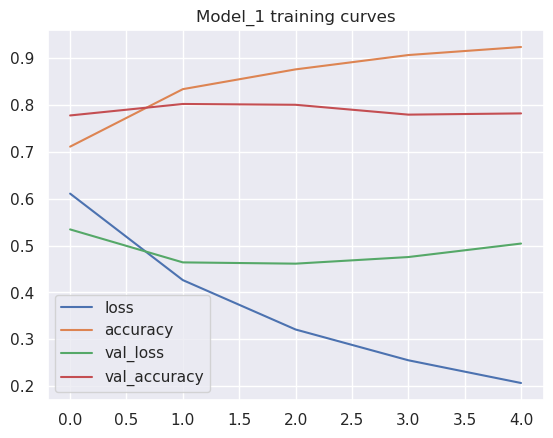

In [35]:
# Plot the loss curves
pd.DataFrame(model_1_history.history).plot()
plt.title("Model_1 training curves")

### Model 2: LSTM

In [36]:
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = Dropout(0.4)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 11)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 11, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 11, 64)            49408     
                                                                 
 dropout (Dropout)           (None, 11, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                      

In [37]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=4,
                              validation_data=(val_sentences, val_labels))

Epoch 1/4
203/203 [==============================] - 13s 37ms/step - loss: 0.5083 - accuracy: 0.7475 - val_loss: 0.4673 - val_accuracy: 0.7846
Epoch 2/4
203/203 [==============================] - 6s 29ms/step - loss: 0.3012 - accuracy: 0.8799 - val_loss: 0.5112 - val_accuracy: 0.7715
Epoch 3/4
203/203 [==============================] - 6s 29ms/step - loss: 0.1982 - accuracy: 0.9264 - val_loss: 0.6031 - val_accuracy: 0.7741
Epoch 4/4
203/203 [==============================] - 6s 30ms/step - loss: 0.1318 - accuracy: 0.9526 - val_loss: 0.6628 - val_accuracy: 0.7496


In [38]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs)) 

# Calculate model_1 metrics
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

36/36 [==============================] - 1s 7ms/step


{'accuracy': 74.95621716287215,
 'precision': 0.7484001146302938,
 'recall': 0.7495621716287215,
 'f1': 0.7485231710387669}

Text(0.5, 1.0, 'Model_2 training curves')

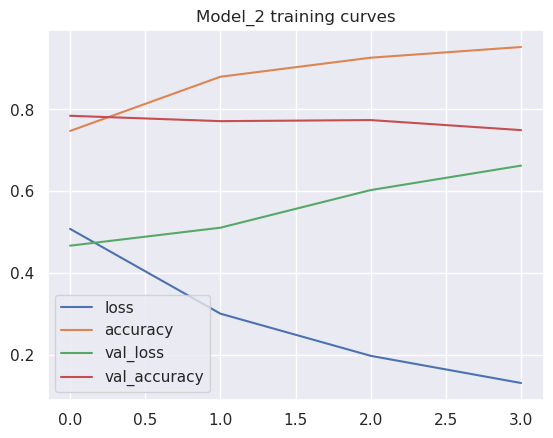

In [39]:
# Plot the loss curves
pd.DataFrame(model_2_history.history).plot()
plt.title("Model_2 training curves")

### Model 3: Bidirectonal RNN model

In [40]:
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = Dropout(0.4)(x)
x = layers.Bidirectional(layers.LSTM(64))(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Bidirectional")

# Compile
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our bidirectional model
model_3.summary()

Model: "model_3_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 11)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 11, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 128)          98816     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 11, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)    

In [41]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
203/203 [==============================] - 22s 56ms/step - loss: 0.5064 - accuracy: 0.7523 - val_loss: 0.4678 - val_accuracy: 0.7828
Epoch 2/5
203/203 [==============================] - 8s 40ms/step - loss: 0.2934 - accuracy: 0.8830 - val_loss: 0.5106 - val_accuracy: 0.7723
Epoch 3/5
203/203 [==============================] - 8s 41ms/step - loss: 0.1740 - accuracy: 0.9414 - val_loss: 0.6004 - val_accuracy: 0.7723
Epoch 4/5
203/203 [==============================] - 8s 40ms/step - loss: 0.1108 - accuracy: 0.9632 - val_loss: 0.8216 - val_accuracy: 0.7522
Epoch 5/5
203/203 [==============================] - 8s 40ms/step - loss: 0.0717 - accuracy: 0.9733 - val_loss: 1.0644 - val_accuracy: 0.7539


In [42]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs)) 

# Calculate model_1 metrics
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

36/36 [==============================] - 2s 9ms/step


{'accuracy': 75.3940455341506,
 'precision': 0.7531804536469972,
 'recall': 0.7539404553415061,
 'f1': 0.7511847202552664}

Text(0.5, 1.0, 'Model_3 training curves')

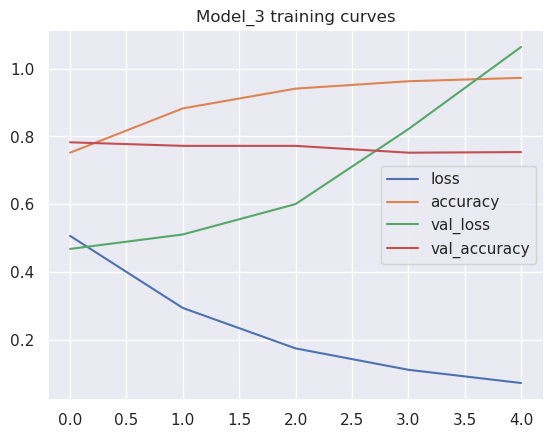

In [43]:
# Plot the loss curves
pd.DataFrame(model_3_history.history).plot()
plt.title("Model_3 training curves")

### Model 4 : Transfer learning

In [44]:
# Universal Sentence Encoder

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [45]:
# Creating model using the Sequential API
model_4 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_4_USE")

# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 256,836,929
Trainable params: 39,105
Non-trainable params: 256,797,824
_________________________________________________________________


In [46]:
# Train a classifier on top of pretrained embeddings
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
203/203 [==============================] - 7s 16ms/step - loss: 0.4938 - accuracy: 0.7648 - val_loss: 0.4517 - val_accuracy: 0.7986
Epoch 2/5
203/203 [==============================] - 2s 12ms/step - loss: 0.4039 - accuracy: 0.8260 - val_loss: 0.4395 - val_accuracy: 0.8039
Epoch 3/5
203/203 [==============================] - 3s 15ms/step - loss: 0.3780 - accuracy: 0.8354 - val_loss: 0.4329 - val_accuracy: 0.8135
Epoch 4/5
203/203 [==============================] - 2s 12ms/step - loss: 0.3482 - accuracy: 0.8493 - val_loss: 0.4412 - val_accuracy: 0.8161
Epoch 5/5
203/203 [==============================] - 3s 13ms/step - loss: 0.3087 - accuracy: 0.8703 - val_loss: 0.4915 - val_accuracy: 0.8126


In [47]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs)) 

# Calculate model_1 metrics
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

36/36 [==============================] - 1s 8ms/step


{'accuracy': 81.26094570928196,
 'precision': 0.822509811747354,
 'recall': 0.8126094570928196,
 'f1': 0.8073450657303141}

Text(0.5, 1.0, 'Model_4 training curves')

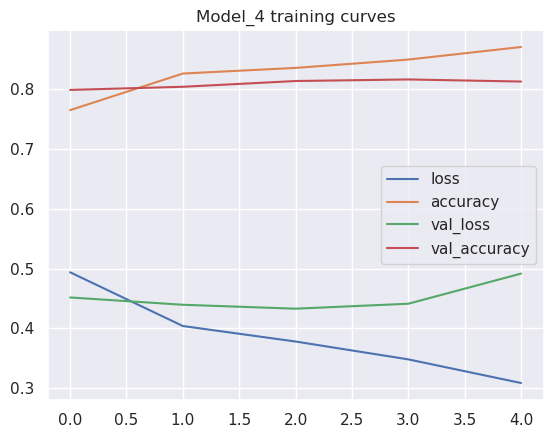

In [48]:
# Plot the loss curves
pd.DataFrame(model_4_history.history).plot()
plt.title("Model_4 training curves")

In [49]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "bidirectional": model_3_results,
                                  "Tranfer ": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.159370,0.799678,0.791594,0.785739
simple_dense,78.196147,0.782719,0.781961,0.778994
lstm,74.956217,0.748400,0.749562,0.748523
bidirectional,75.394046,0.753180,0.753940,0.751185
Tranfer,81.260946,0.822510,0.812609,0.807345


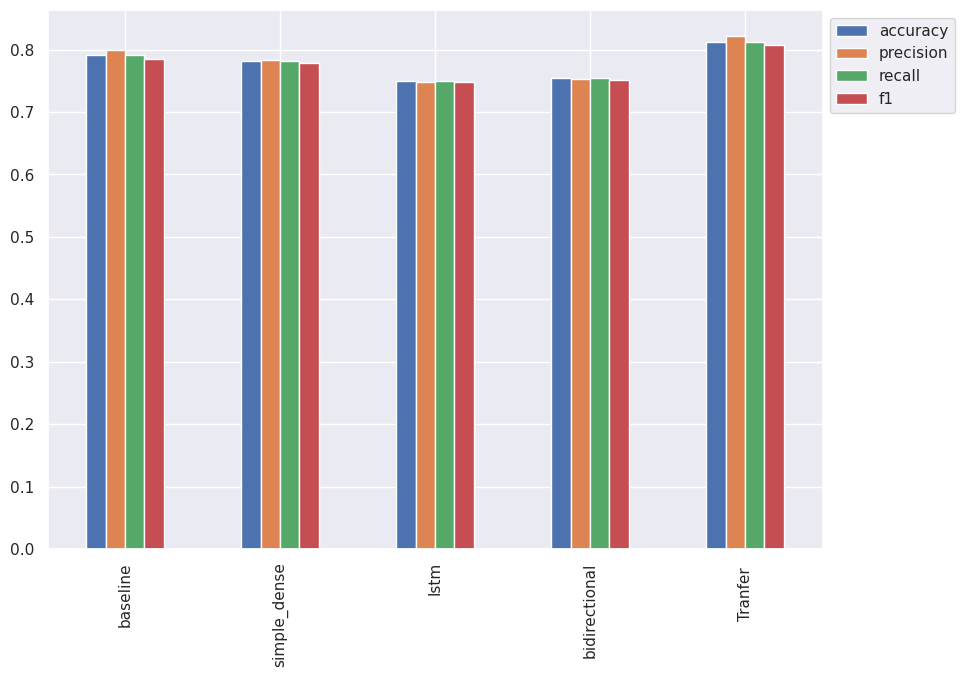

In [50]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## ★·.·´¯·.·★ Ｔℍᗩ𝕟Ⓚ ㄚ𝕠𝓤 ★·.·´¯·.·★